In [ ]:
#Diseñar un algoritmo que sea capaz de detectar y dibujar automaticamente las rectas.
 
#Extraer la posicion de las lineas exteriores y la linea central de la cancha en la imagen
#Primero: Eliminar ruido 
#Segundo: Tecnica de busqueda y ajuste de lineas en la imagen. RANSAC, Hough o barrido horizontal o vertical. SOLO SE PERMITE UTILIZAR FUNCIONES PARA RESOLVER SISTEMAS POR MINIMOS CUADRADOS
#Tercero: Non-Max-Suppressio, elegir entre detecciones multiples de la misma recta y definir una deteccion unica entre lineas -analizar el angulo entre las rectas-.

In [42]:
# ! pip install ../cvum
# ! pip install opencv-python
# ! pip install matplotlib
import cv2
import argparse
import numpy as np
from sympy import symbols, solveset, Eq
from cvum.utils import add_snp_noise
from cvum.utils import imread_rgb
from cvum.utils import correlationdot_2D
from sympy.solvers import solve
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import math
import scipy.ndimage as ndimage

[[[193.          1.5184364]]

 [[191.          1.5184364]]]
[INFO] angulo: -3.00000


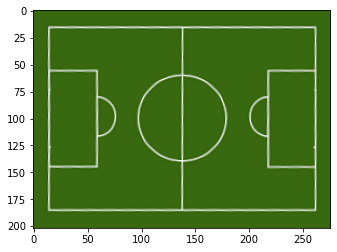

In [43]:
#Enderezar img

img = cv2.imread('./images/football.png') #Cargamos imagen


def estan_cercanos(a1, a2, error):
    cases = np.unwrap([a2-error, a1, a2 + error])
    return cases[0] <= cases[1] <= cases[2]

def enderezar(entrada, salida):
    # Leer la imagen
    imagen = cv2.imread(entrada)

    # Convertirla a gris y detectar bordes
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    binaria = cv2.Canny(gray,50,150,apertureSize = 3)
    # Usar la transformada de Hough para encontrar líneas
    # en la imagen binarizada, con una resolución de medio
    # grado (pi/720) y quedándose sólo con las líneas que
    # alcancen puntuación de 1000 o más (que serán las
    # más largas)
    lineas = cv2.HoughLines(binaria, 1, np.pi/720, 200)
    print(lineas)
    # Recopilemos qué ángulos ha encontrado la transformada
    # de hough para cada una de las líneas halladas
    angulos = []
    for linea in lineas:
        rho, theta = linea[0]
        if rho<0:
            theta = -theta

        # Quedarse solo con las rayas próximas a la horizontal
        # (con un error de +-10 grados)
        if not estan_cercanos(theta, np.pi/2, np.deg2rad(10)):
           continue;

        angulos.append(theta)

    # Ahora contemos cuántas veces aparece cada ángulo
    from collections import Counter
    veces = Counter(angulos)

    # Quedémonos con los tres casos más frecuentes
    frecuentes = veces.most_common(3)

    # Y calculemos el promedio de esos tres casos
    suma = sum(angulo*repeticion for angulo,repeticion in frecuentes)
    repeticiones = sum(repeticion for angulo, repeticion in frecuentes)
    angulo = suma/repeticiones

    angulo = np.rad2deg(angulo - np.pi/2)
    print("[INFO] angulo: {:.5f}".format(angulo))

    # Ahora enderecemos la imagen, girando el ángulo detectado
    (h, w) = imagen.shape[:2]
    centro = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(centro, angulo, 1.0)

    girada = cv2.warpAffine(imagen, M, (w, h),
                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Y volcamos a disco el resultado
    cv2.imwrite(salida, girada)

    plt.imshow(girada)



    
enderezar('./images/football.png','./images/derecha.png')


In [44]:
#Luego de tener la imagen recta, hay que detectar lineas, primero eliminamos ruido

In [45]:
def hough_space(canny_matrix, theta, theta_max, theta_min):
    r_dim = 200 
    theta_dim = 300
    hough_space = np.zeros((r_dim, theta_dim))
    m = len(canny_matrix)
    n = len(canny_matrix[0])
    for y in range(0, n):
        for x in range(0, m):
            if canny_matrix[x][y] == 255:
                for itheta in range(int(theta)):
                    theta = 1.0 * itheta * theta_max / theta
                    r = x * math.cos(theta) + y * math.sin(theta)
                    ir = r_dim * ( 1.0 * r ) / r_max
                    hough_space[ir,itheta] = hough_space[ir,itheta] + 1
    return hough_space

In [46]:
# hough_space = np.zeros((r_dim,theta_dim))

# for x in range(0, x_max):
#   for y in range(0, y_max):
#     if img[x,y,0] == 255:
#       for itheta in range(theta_dim):
#         theta = 1.0 * itheta * theta_max / theta_dim
#         r = x * math.cos(theta) + y * math.sin(theta)
#         ir = r_dim * ( 1.0 * r ) / r_max
#         hough_space[int(ir),itheta] = hough_space[int(ir),itheta] + 1

In [59]:
# Remove noise and detect Hough Space

img = cv2.imread('./images/derecha.png')

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 360  # angular resolution in radians of the Hough grid
threshold = 8  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 160  # minimum number of pixels making up a line
max_line_gap = 3  # maximum gap in pixels between connectable line segments
low_threshold = 50
high_threshold = 150
theta_max = np.pi * 1.0
theta_min = 0.0
r_dim = 200 
theta_dim = 300
neighborhood_size = 20

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 7
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

canny_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

img_shape = img.shape
x_max = img_shape[0]
y_max = img_shape[1]

r_min = 0.0
r_max = math.hypot(x_max, y_max)
# hough_space = hough_space(canny_edges, theta, theta_min, theta_max)

hough_space = np.zeros((r_dim,theta_dim))

for x in range(0, x_max):
  for y in range(0, y_max):
    if img[x,y,0] == 255:
      for itheta in range(theta_dim):
        theta = 1.0 * itheta * theta_max / theta_dim
        r = x * math.cos(theta) + y * math.sin(theta)
        ir = r_dim * ( 1.0 * r ) / r_max
        hough_space[int(ir),itheta] = hough_space[int(ir),itheta] + 1

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0
[]


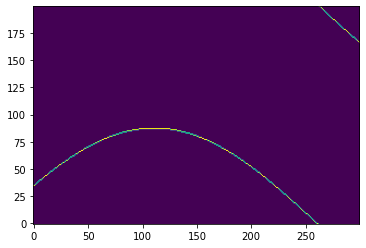

In [60]:
#Detect max and mins

data_max = ndimage.filters.maximum_filter(hough_space, neighborhood_size)
maxima = (hough_space == data_max)

data_min = ndimage.filters.minimum_filter(hough_space, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
print(labeled)
print(num_objects)

slices = ndimage.find_objects(labeled)
print(slices)

x, y = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)

plt.imshow(hough_space, origin='lower')
# plt.savefig('hough_space_i_j.png', bbox_inches = 'tight')

plt.autoscale(False)
plt.plot(x,y, 'ro')
# plt.savefig('hough_space_maximas.png', bbox_inches = 'tight')
# plt.close()

In [57]:
# Draw lines

line_index = 1
for i,j in zip(y, x):

    r = round( (1.0 * i * r_max ) / r_dim,1)
    theta = round( (1.0 * j * theta_max) / theta_dim,1)

    fig, ax = plt.subplots()

    ax.imshow(img)

    ax.autoscale(False)

    px = []
    py = []
    for i in range(-y_max-40,y_max+40,1):
        px.append( math.cos(-theta) * i - math.sin(-theta) * r ) 
        py.append( math.sin(-theta) * i + math.cos(-theta) * r )

    ax.plot(px,py, linewidth=5)

    #plt.savefig("image_line_"+ "%02d" % line_index +".png",bbox_inches='tight')

    plt.show()

#     plt.close()

    line_index = line_index + 1

[]
[]
